In [26]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, maxabs_scale
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from model import MeronSmart, ml_models

In [3]:
meron = MeronSmart()

In [4]:
dense_model = meron.build_model(reg_val=None)

In [6]:
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                8384      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 8,579
Trainable params: 8,579
Non-trainable params: 0
_________________________________________________________________


In [7]:
merged_df = pd.read_csv('/data/meron/kenya_data/meron_merged_df.csv')
meta_data = pd.read_csv('/data/meron/kenya_data/meron_link_data/meron_meta_processed.csv')

In [8]:
target = np.array(merged_df[['maln_mam','maln_normal','maln_sam']])

In [9]:
num_mam = merged_df['maln_mam'].sum()
num_normal = merged_df['maln_normal'].sum()
num_sam = merged_df['maln_sam'].sum()
counts = [num_mam, num_normal, num_sam]
names = ('mam', 'normal','sam')
print('proportion of normal in dataset: {}'.format(num_normal/np.sum(counts)))

proportion of normal in dataset: 0.8365758754863813


([<matplotlib.axis.XTick at 0x7f547dadb400>,
 <a list of 3 Text xticklabel objects>)

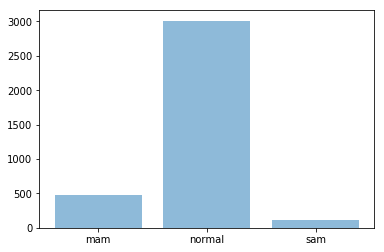

In [13]:
plt.bar(np.arange(len(names)),counts, align='center', alpha=0.5)
plt.xticks(np.arange(len(names)), names)

In [10]:
deselect_cols = ['photo_id','maln_mam','maln_normal','maln_sam']

In [11]:
select = [x for x in merged_df.columns if x not in deselect_cols]
data_features = merged_df.loc[:, select]
data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,gender_male,age_months
0,0.0,0.0,0.0,0.0,0.0,1.610925,0.0,0.0,0.0,0.549768,...,0.774492,0.0,0.0,1.000045,1.170272,0.921167,1.242629,0.687481,0,16
1,0.0,0.0,0.0,0.0,0.0,1.445036,0.0,0.0,0.0,1.647060,...,0.786660,0.0,0.0,0.799522,1.862234,1.719354,1.834410,1.012238,1,43
2,0.0,0.0,0.0,0.0,0.0,1.350020,0.0,0.0,0.0,1.408485,...,1.505267,0.0,0.0,0.286310,1.878455,1.789453,1.777737,0.666670,0,44
3,0.0,0.0,0.0,0.0,0.0,1.489869,0.0,0.0,0.0,0.685115,...,0.598133,0.0,0.0,0.550220,1.577498,0.903224,1.778716,1.166920,1,14
4,0.0,0.0,0.0,0.0,0.0,0.862583,0.0,0.0,0.0,0.998975,...,0.975411,0.0,0.0,0.536872,1.273720,0.870286,0.823969,1.012618,0,7


# Split data into training and testing sets, then train model

In [12]:
### scale/standardize the features?
conv_scaler = StandardScaler().fit(data_features)
data_features_scaled = conv_scaler.transform(data_features)
data_features_scaled

array([[ 0.        ,  0.        ,  0.        , ..., -1.18780391,
        -1.02761861, -0.97103382],
       [ 0.        ,  0.        ,  0.        , ...,  0.03142577,
         0.97312368,  0.81073245],
       [ 0.        ,  0.        ,  0.        , ..., -1.26593645,
        -1.02761861,  0.87672379],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.15373222,
         0.97312368,  0.87672379],
       [ 0.        ,  0.        ,  0.        , ..., -1.30145252,
        -1.02761861,  1.14068917],
       [ 0.        ,  0.        ,  0.        , ..., -0.60876649,
        -1.02761861, -1.43297323]])

In [24]:
### Break data into training and test (stratified)
X_train, X_test, y_train, y_test = train_test_split(data_features_scaled, target, test_size=0.2, random_state=42, 
                                                    stratify=target)

In [14]:
print(X_train.shape)
print(X_test.shape)

(2878, 130)
(720, 130)


In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('dense_model_smart_3layers(dropout_scaled3).h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

In [16]:
## compute class weight
w = compute_class_weight('balanced', np.unique(meta_data.maln_class), meta_data.maln_class)
w

array([ 2.51391255,  0.39947663, 10.10730594])

dense_model.compile(loss='categorical_crossentropy',
                               optimizer=Adam(lr=1e-6),
                               metrics=['accuracy'])

In [25]:
dense_model.fit(X_train,
                y_train,
                epochs=2000,
                batch_size=512,
                callbacks=[checkpoint, early_stop],
                shuffle=True,
                validation_data=(X_test, y_test),
                class_weight=meron._get_class_weights(meta_data.maln_class, neural_net=True),
                verbose=1)

Train on 2878 samples, validate on 720 samples
Epoch 1/2000
2878/2878 [==============================] - 0s 14us/step - loss: 0.9159 - acc: 0.5413 - val_loss: 1.0077 - val_acc: 0.4875

Epoch 00001: val_loss did not improve from 0.89847
Epoch 2/2000
2878/2878 [==============================] - 0s 13us/step - loss: 0.9110 - acc: 0.5400 - val_loss: 1.0048 - val_acc: 0.4833

Epoch 00002: val_loss did not improve from 0.89847
Epoch 3/2000
2878/2878 [==============================] - 0s 13us/step - loss: 0.9179 - acc: 0.5354 - val_loss: 1.0016 - val_acc: 0.4833

Epoch 00003: val_loss did not improve from 0.89847
Epoch 4/2000
2878/2878 [==============================] - 0s 13us/step - loss: 0.9136 - acc: 0.5424 - val_loss: 0.9993 - val_acc: 0.4806

Epoch 00004: val_loss did not improve from 0.89847
Epoch 5/2000
2878/2878 [==============================] - 0s 12us/step - loss: 0.8893 - acc: 0.5500 - val_loss: 0.9981 - val_acc: 0.4806

Epoch 00005: val_loss did not improve from 0.89847
Epoch 6/